# <a id='toc1_'></a>[Recommender System Design Based on Customer's Online Shopping Behavior](#toc0_)

Group Member: 李辰曦 龚彦同 夏江林 王前

**Table of contents**<a id='toc0_'></a>    
- [Recommender System Design Based on Customer's Online Shopping Behavior](#toc1_)    
  - [User and Real Sessions](#toc1_1_)    
  - [Event dependency percentages](#toc1_2_)    
    - [Order after add to cart](#toc1_2_1_)    
    - [Add to cart after click](#toc1_2_2_)    
    - [Click after click](#toc1_2_3_)    
  - [Comparison of different event types](#toc1_3_)    
    - [Distribution of number of products viewed by customers](#toc1_3_1_)    
    - [Event distribution across entire userbase¶](#toc1_3_2_)    
    - [Number of products viewed vs. number of products ordered¶](#toc1_3_3_)    
    - [Distribution of number of products ordered by customers](#toc1_3_4_)    
    - [Distribution of number of products clicked](#toc1_3_5_)    
    - [Distribution of number of products added to cart](#toc1_3_6_)    
    - [Number of products ordered vs. number of products clicked](#toc1_3_7_)    
    - [Number of products ordered vs. number of products added to cart](#toc1_3_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [29]:
import random

import numpy as np
import pandas as pd
import polars as pl

from matplotlib import dates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Because our train data are large (about 10 GB), it is hard to read the json file by pandas directly (out of memory). Therefore, we devided these data in chunks, then we merge the chunks.

In [3]:
%%time
chunks =pd.read_json('../data_json/train.jsonl', lines=True, chunksize=100_000)

train = pd.DataFrame()

for i, chunk in enumerate(chunks):
    event_dict = {
        'session': [],
        'aid': [],
        'ts': [],
        'type': []
    }

    if i >= 2:
        break
    for session, events in zip(chunk['session'].tolist(), \
                               chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    train = pd.concat([train, chunk_session])

CPU times: user 15.4 s, sys: 5.33 s, total: 20.8 s
Wall time: 22.5 s


In [4]:
train = train.reset_index(drop=True)
display(train)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


## <a id='toc1_1_'></a>[User and Real Sessions](#toc0_)

In this section, we display users and their real session by showing the temporal characteristics of the data. We observe that users exhibt regular patterns of session behavior. These observations can help us characterize and engineer features for users. These observations can also give us insight into predicting future `click`, `cart` and `order` behavior.

In [5]:
# copy the train dataframe for time-series analysis
df_series = train.copy(deep=True)
display(df_series)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


First, it is necessary to process a portion of the data in order to facilitate the presentation of time series features.

The column `ts` means timestamp, we need to transfer timestamp to the type like `YYYY-MM-DD hh:mm:ss`. To facilitate analysis, we alse need to encode the column `type`. Then we compute the day and hour of users' activities, and filter the users who each have over 40 item interactions.

In [6]:
# timestamp transfer
df_series.ts = pd.to_datetime(df_series.ts * 1e6)

# encode propety type
type_to_num = {'clicks': 0,
               'carts': 1,
               'orders': 2}
df_series['type'] = df_series['type'].map(type_to_num)
display(df_series)


,session,aid,ts,type
0,0,1517085,2022-07-31 22:00:00.024999936,0
1,0,1563459,2022-07-31 22:01:44.511000064,0
2,0,1309446,2022-08-01 15:23:59.425999872,0
3,0,16246,2022-08-01 15:28:39.996999936,0
4,0,1781822,2022-08-01 15:31:11.344000000,0
...,...,...,...,...
10285556,199999,928064,2022-08-01 06:46:48.967000064,0
10285557,199999,849970,2022-08-01 06:47:29.078000128,0
10285558,199999,1052480,2022-08-01 06:49:07.035000064,0
10285559,199999,487255,2022-08-01 06:49:21.116000000,0


In [7]:
df_series = df_series.loc[df_series.ts >= pd.to_datetime('2022-08-01')]

In [8]:
# Compute day and hour of activities
df_series['day'] = df_series.ts.dt.day
df_series['hour'] = df_series.ts.dt.hour
df_series = df_series.reset_index(drop=True)

tmp = df_series.groupby('session').aid.agg('count').rename('n')
df_series = df_series.merge(tmp, on='session')
frequent_users = df_series.loc[df_series.n > 40, 'session'].unique()
print(f'There are {len(frequent_users)} users who each have over 40 item interactions')

There are 65650 users who each have over 40 item interactions


We find real sessions by finding gaps of 2 hours or more between activity. Then we label these gaps as `1` and everything else as `0`. Lastly we perform a groupby `cumsum` to locate sessions.

In [9]:
# compute user real session
df_series.ts = df_series.ts.astype('int64')/1e9
# replicate groupby diff
df_series = df_series.sort_values(['session', 'ts']).reset_index(drop=True)
df_series['d'] = df_series.ts.diff()
df_series.loc[df_series.session.diff()!=0, 'd'] = 0
# Identity real user sessions when we see 2 hour pause in activity
df_series.d = (df_series.d > 60*60*2).astype('int8').fillna(0)
df_series['d'] = df_series.groupby('session').d.cumsum()

The mean session count per train user is 9.9 with right skewed distribution below


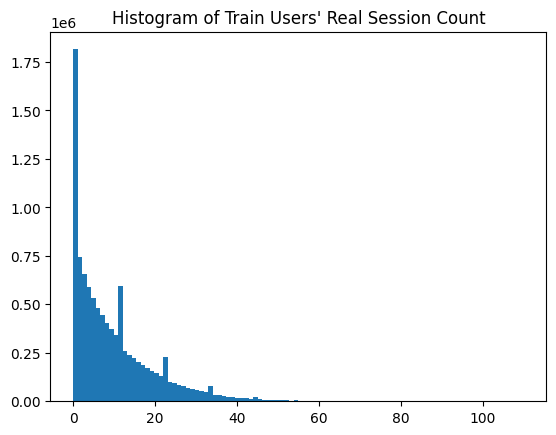

In [10]:
plt.hist(df_series.d, bins=100)
plt.title("Histogram of Train Users' Real Session Count")
m = df_series.d.mean()
print(f'The mean session count per train user is {m:0.1f} with right skewed distribution below')
plt.show()

Below we display a scatter plot with jitter. The x axis is day of the month August 2022. And the y axis is hour of the day. Many dots would fall on top of each other, so we add random x and y jitter. Also we color the `clicks` blue, `carts` orange, and `orders` red. We plot the `clicks` first, then `carts`, then `orders`. This guarentees that the `orders` and `carts` (when present) will always be visible and not be obscured by `click` dots.

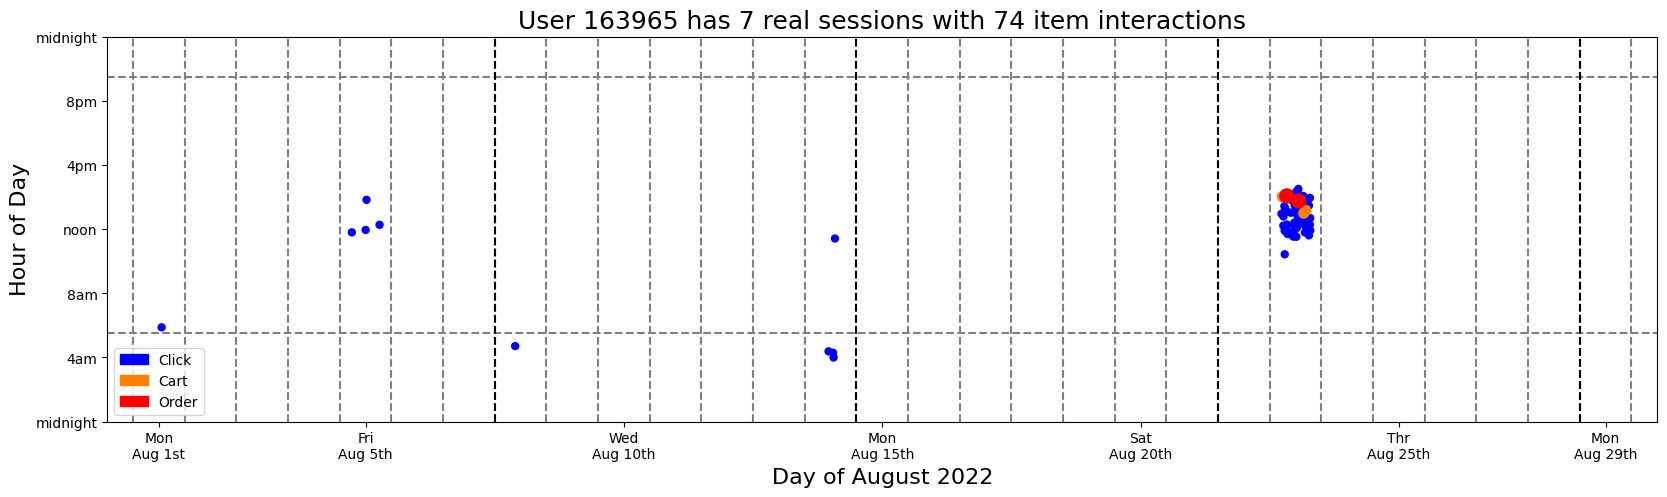

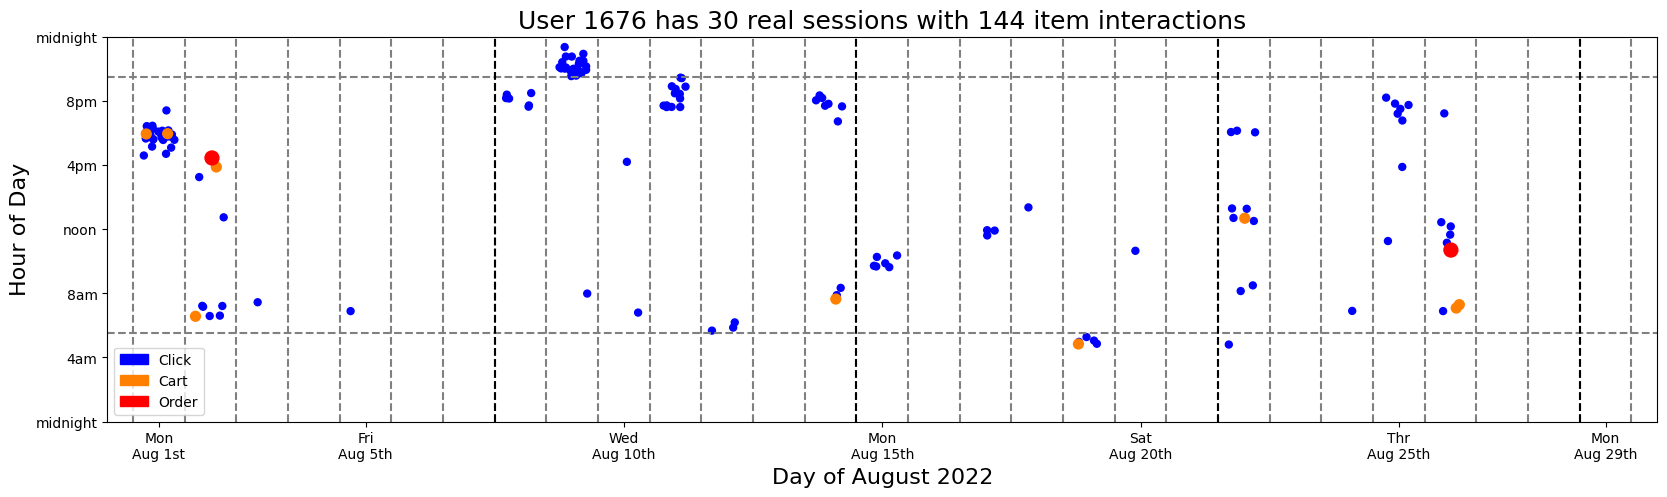

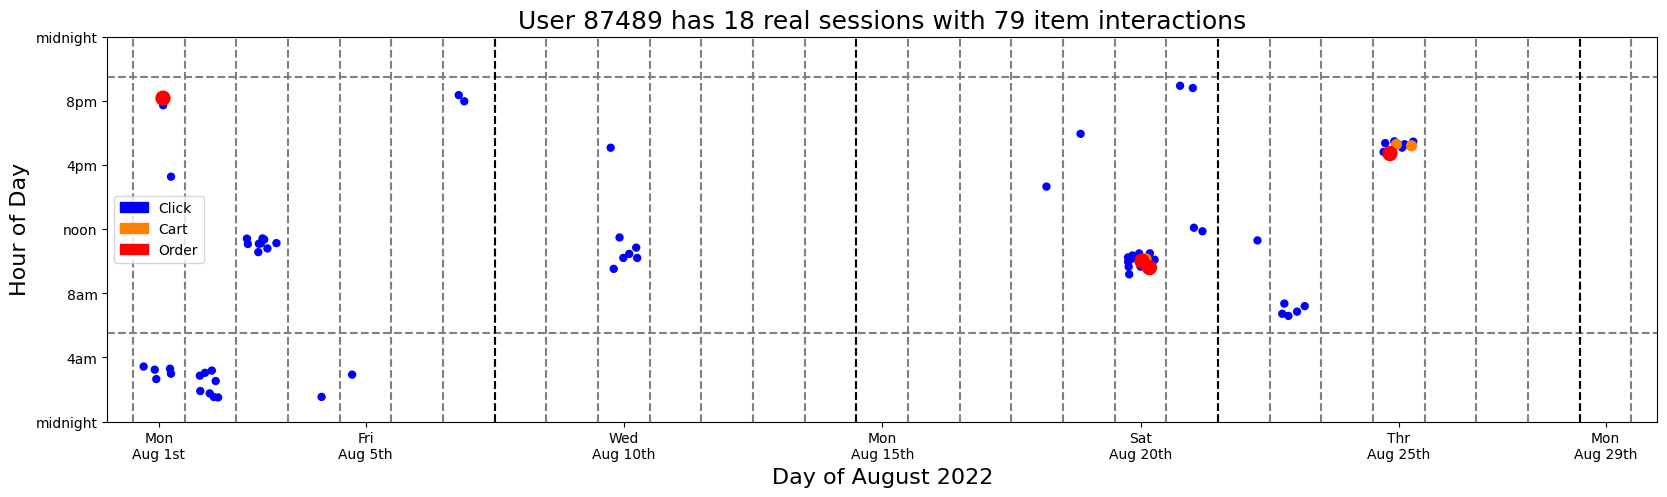

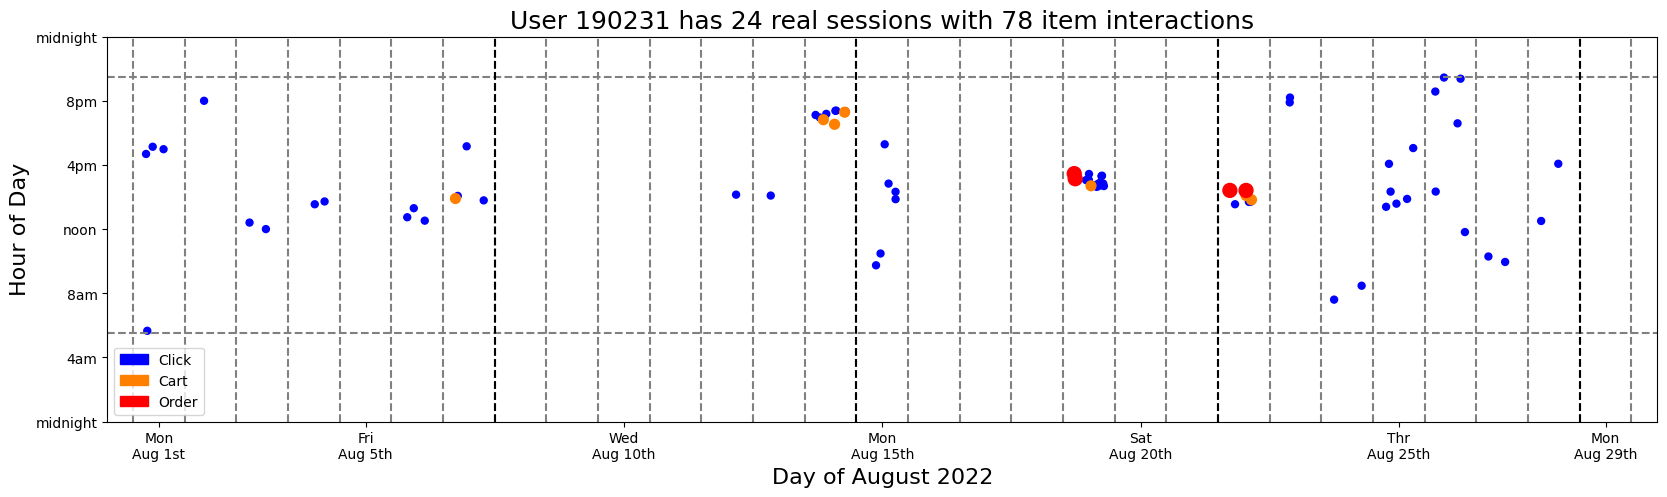

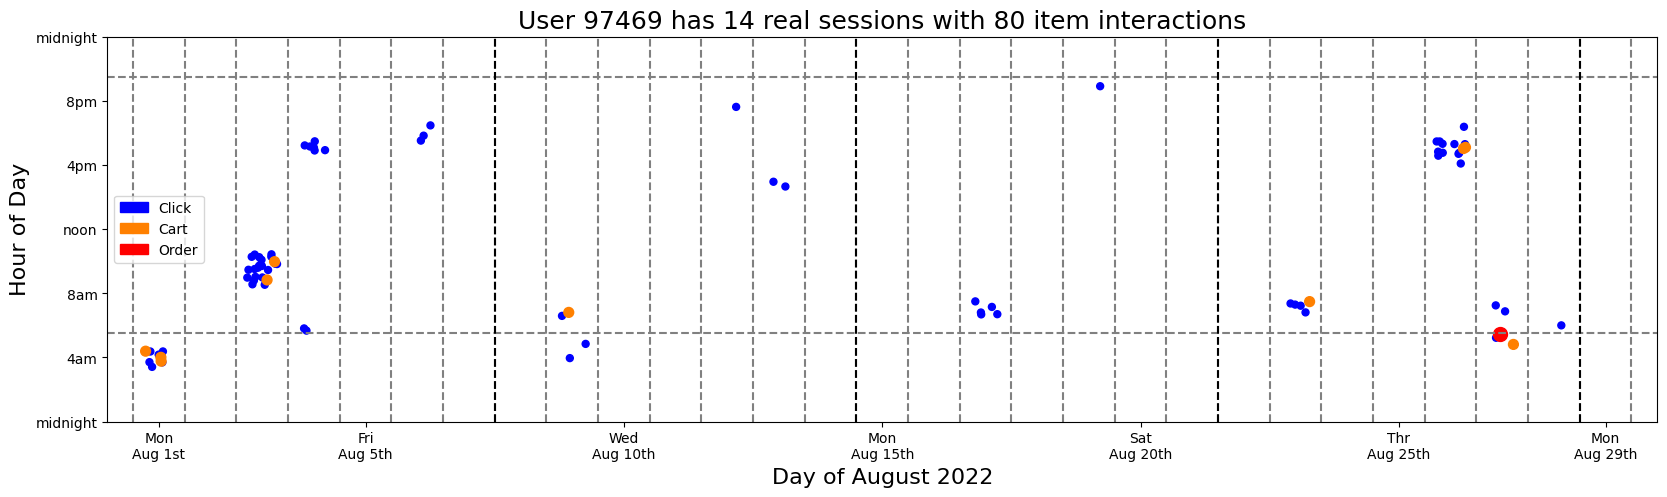

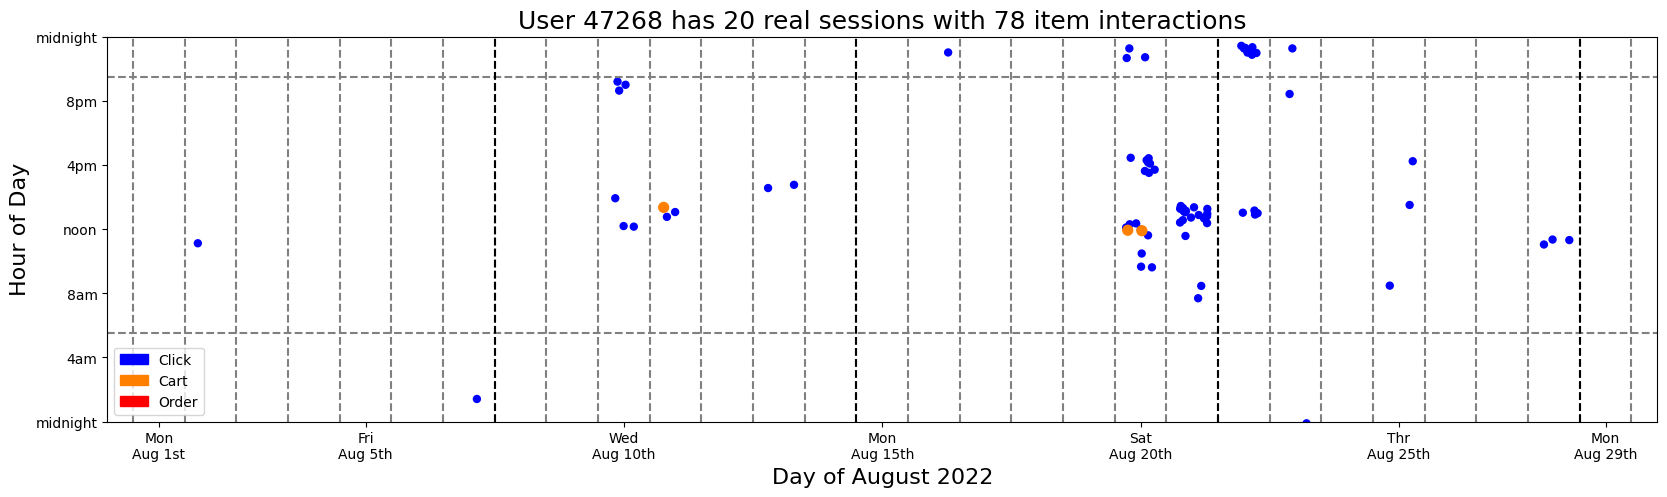

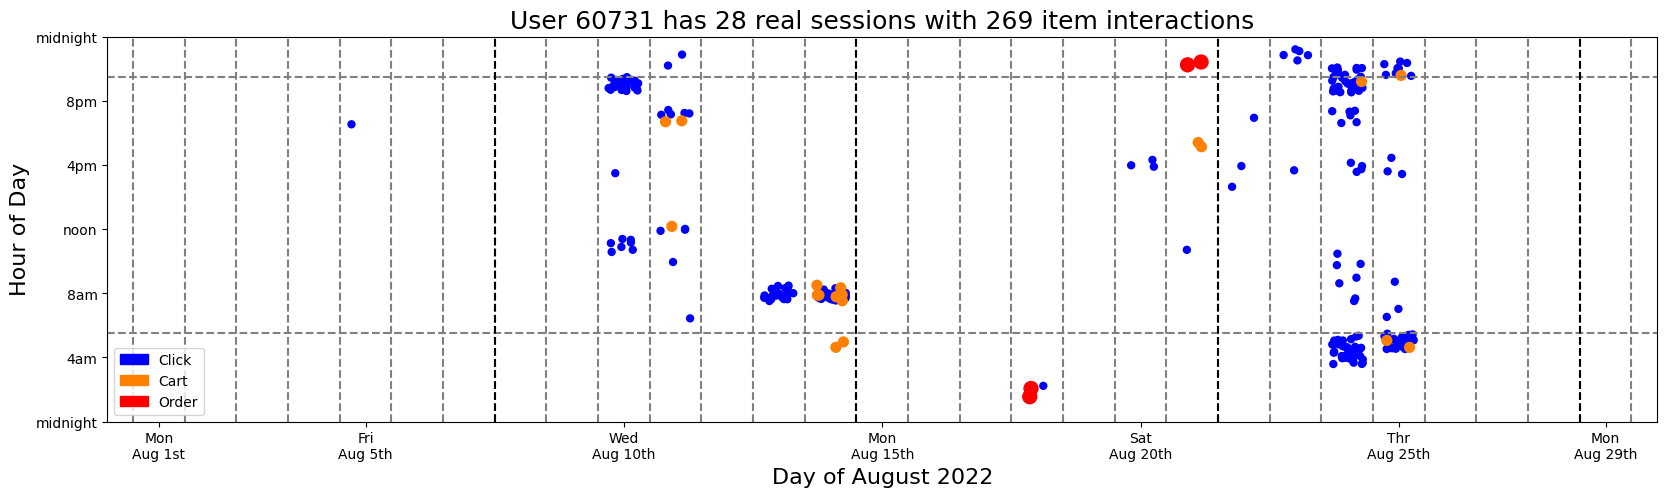

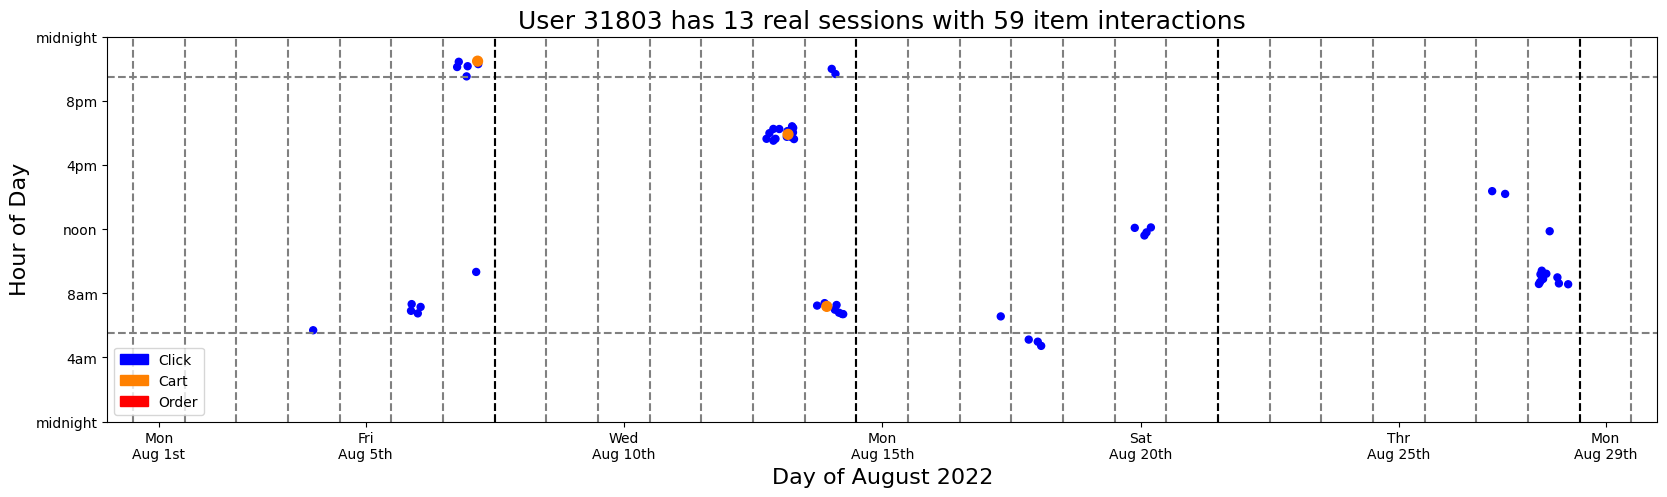

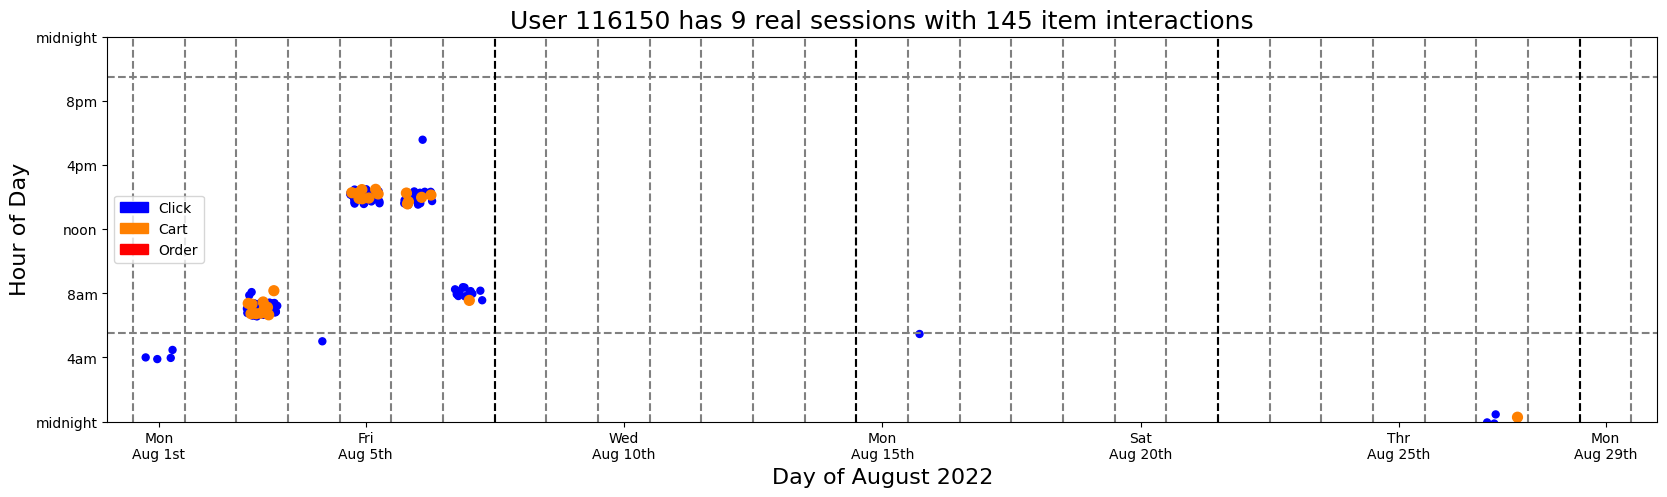

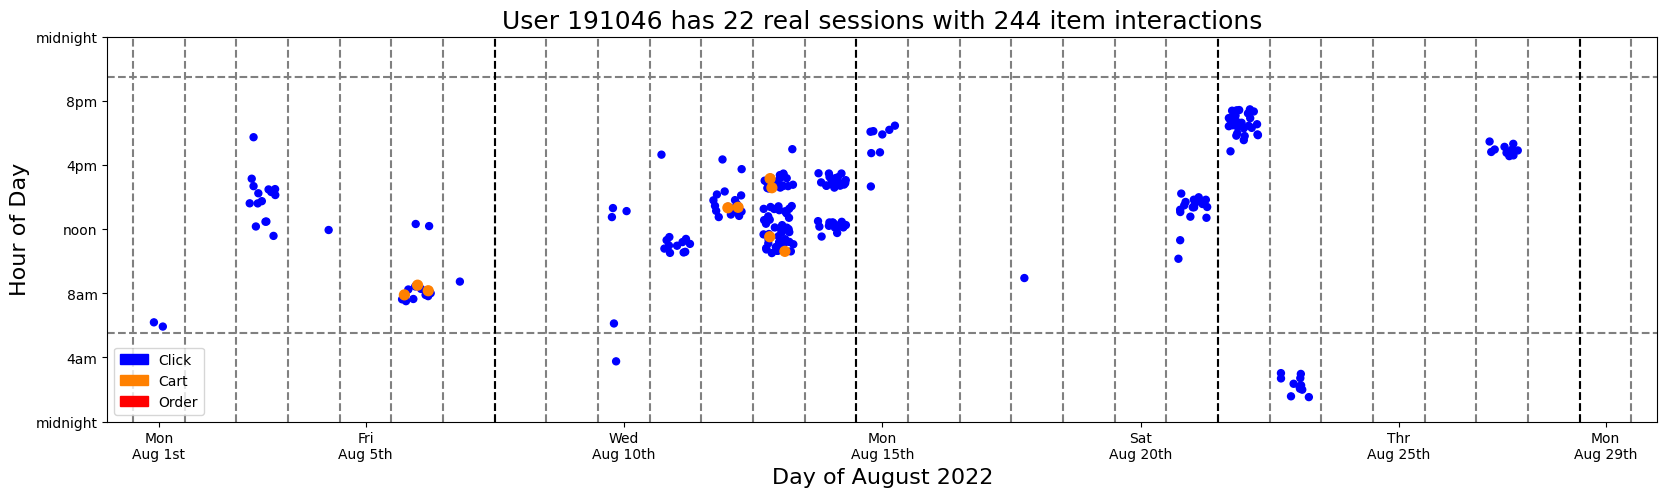

In [11]:
colors = np.array( [(0,0,1),(1,0.5,0),(1,0,0)] )

for k in range(10):
    u = np.random.choice(frequent_users)
    tmp = df_series.loc[df_series.session==u]

    ss = tmp.d.max()+1
    ii = len(tmp)
    
    plt.figure(figsize=(20,5))
    for j in [0,1,2]:
        s = 25
        if j==1: s=50
        elif j==2: s=100
        tmp2 = tmp.loc[tmp['type']==j]
        xx = np.random.uniform(-0.3,0.3,len(tmp2))
        yy = np.random.uniform(-0.5,0.5,len(tmp2))
        plt.scatter(tmp2.day.values+xx, tmp2.hour.values+yy, s=s, c=colors[tmp2['type'].values])
    plt.ylim((0,24))
    plt.xlim((0,30))
    c1 = mpatches.Patch(color=colors[0], label='Click')
    c2 = mpatches.Patch(color=colors[1], label='Cart')
    c3 = mpatches.Patch(color=colors[2], label='Order')
    plt.plot([0,30],[6-0.5,6-0.5],'--',color='gray')
    plt.plot([0,30],[21+0.5,21+0.5],'--',color='gray')
    for k in range(0,30):
        plt.plot([k+0.5,k+0.5],[0,24],'--',color='gray')
    for k in range(1,5):
        plt.plot([7*k+0.5,7*k+0.5],[0,24],'--',color='black')
    plt.legend(handles=[c1,c2,c3])
    plt.xlabel('Day of August 2022',size=16)
    plt.xticks([1,5,10,15,20,25,29],['Mon\nAug 1st','Fri\nAug 5th','Wed\nAug 10th','Mon\nAug 15th','Sat\nAug 20th','Thr\nAug 25th','Mon\nAug 29th'])
    plt.ylabel('Hour of Day',size=16)
    plt.yticks([0,4,8,12,16,20,24],['midnight','4am','8am','noon','4pm','8pm','midnight'])
    plt.title(f'User {u} has {ss} real sessions with {ii} item interactions',size=18)
    plt.show()
    print('\n\n')

## <a id='toc1_2_'></a>[Event dependency percentages](#toc0_)

Next, we analyse the customer's behaviour. The order in which the three events in the data occurred was counted to answer the following three questions:
- In what fraction of instances an order event happens after add to cart (0.63%)
- In what fraction of instances an add to cart event occurs after a click event (5.89%)
- In what fraction of instances a click event occurs after a click event (83.64%)

In [12]:
df_event = train.copy(deep=True)
df_event.rename(index=str, columns={'session': 'customer_id',
                                 'aid' : 'product_code',
                                 'ts' : 'time_stamp',
                                 'type' : 'event_type'}, inplace=True)
df_event['time_stamp'] = pd.to_datetime(df_event['time_stamp'], unit='ms')
display(df_event)

,customer_id,product_code,time_stamp,event_type
0,0,1517085,2022-07-31 22:00:00.025,clicks
1,0,1563459,2022-07-31 22:01:44.511,clicks
2,0,1309446,2022-08-01 15:23:59.426,clicks
3,0,16246,2022-08-01 15:28:39.997,clicks
4,0,1781822,2022-08-01 15:31:11.344,clicks
...,...,...,...,...
10285556,199999,928064,2022-08-01 06:46:48.967,clicks
10285557,199999,849970,2022-08-01 06:47:29.078,clicks
10285558,199999,1052480,2022-08-01 06:49:07.035,clicks
10285559,199999,487255,2022-08-01 06:49:21.116,clicks


### <a id='toc1_2_1_'></a>[Order after add to cart](#toc0_)

In [13]:
# Percentage of orders occuring after add to cart events
df_event['order'] = df_event['event_type'].apply(lambda x: 1 if x == 'orders' else 0)
df_event['add_to_cart'] = df_event['event_type'].apply(lambda x: 1 if x == 'carts' else 0)
df_event['order_after_cart'] = df_event['order'].shift(-1) + df_event['add_to_cart']
df_event['order_after_cart'] = df_event['order_after_cart'].apply(lambda x: 1 if x == 2 else 0)

perc = df_event['order_after_cart'].value_counts(normalize=True)[1]

print(f'Percentage of orders occuring after add to cart events: {perc:.2%}')

Percentage of orders occuring after add to cart events: 0.63%


### <a id='toc1_2_2_'></a>[Add to cart after click](#toc0_)

In [14]:
# Percentage of add_to_cart events occuring after click events
df_event['click'] = df_event['event_type'].apply(lambda x: 1 if x == 'clicks' else 0)
df_event['cart_after_click'] = df_event['click'].shift(-1) + df_event['add_to_cart']
df_event['cart_after_click'] = df_event['cart_after_click'].apply(lambda x: 1 if x == 2 else 0)

perc = df_event['cart_after_click'].value_counts(normalize=True)[1]

print(f'Percentage of add_to_cart events occuring after click events: {perc:.2%}')

Percentage of add_to_cart events occuring after click events: 5.89%


### <a id='toc1_2_3_'></a>[Click after click](#toc0_)

In [15]:

# Percentage of click events occuring after click events
df_event['click_after_click'] = df_event['click'].shift(-1) + df_event['click']
df_event['click_after_click'] = df_event['click_after_click'].apply(lambda x: 1 if x == 2 else 0)

perc = df_event['click_after_click'].value_counts(normalize=True)[1]

print(f'Percentage of click events occuring after click events: {perc:.2%}')

Percentage of click events occuring after click events: 83.64%


## <a id='toc1_3_'></a>[Comparison of different event types](#toc0_)

In this section, we display the relationship of the three event types (`click`, `cart` and `order`). We will display the distribution of the three types respectively and show the plot of the comparision between each two types.

In [16]:
grouped_train = train.groupby('session').count()
display(grouped_train)

,aid,ts,type
session,,,
0,276,276,276
1,32,32,32
2,33,33,33
3,226,226,226
4,19,19,19
...,...,...,...
199995,17,17,17
199996,25,25,25
199997,154,154,154


### <a id='toc1_3_1_'></a>[Distribution of number of products viewed by customers](#toc0_)

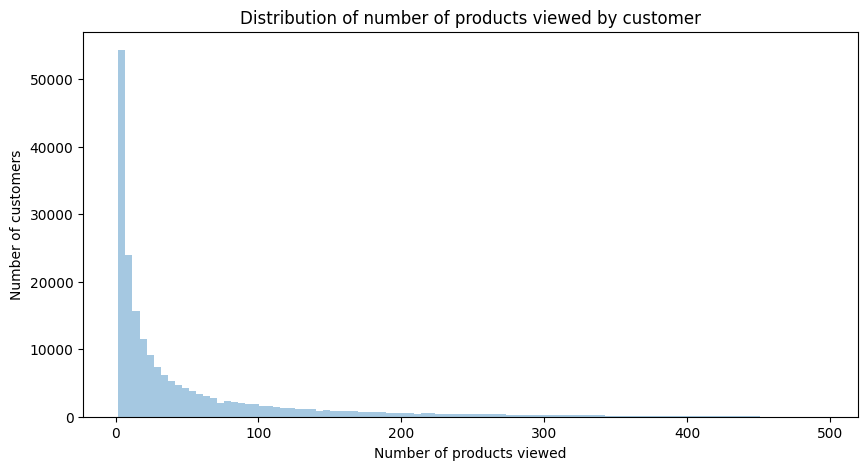

In [17]:
plt.figure(figsize=(10, 5))
sns.distplot(grouped_train['aid'], kde=False, bins=100)
plt.title('Distribution of number of products viewed by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of customers')
plt.show()

### <a id='toc1_3_2_'></a>[Event distribution across entire userbase](#toc0_)

Majority of the events in the sampled data are clicks, followed by addition to carts and orders. It is evident that a very small chunk of customers sessions translate to a conversion. At this point it will be interesting to understand the relationship b/w length of the session and the conversion rate.

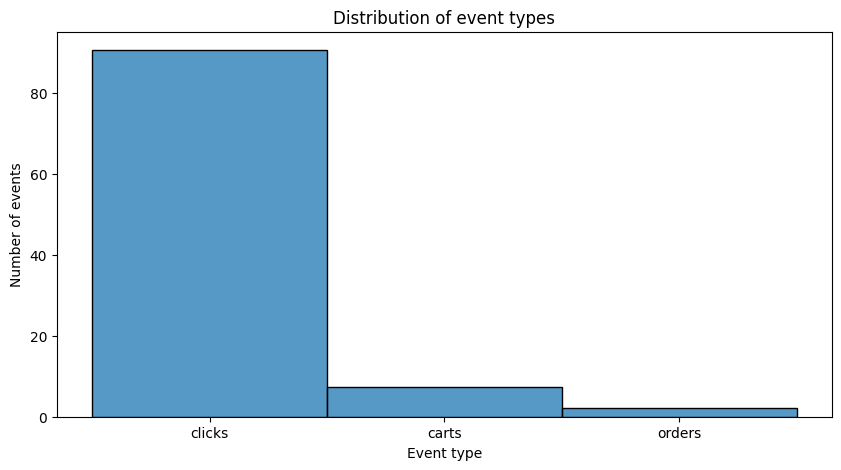

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(train['type'], stat='percent', kde=False, bins=100)
plt.title('Distribution of event types')
plt.xlabel('Event type')
plt.ylabel('Number of events')
plt.show()

### <a id='toc1_3_3_'></a>[Number of products viewed vs. number of products ordered](#toc0_)

There seems to be a slight correlation b/w number of products viewed vs number of products ordered by a customer.

In [19]:
grouped_train_orders = train[train['type'] == 'orders'].groupby('session').count().join(grouped_train, lsuffix='_orders', rsuffix='_views')   
grouped_train_orders = grouped_train_orders.drop(['aid_views', 'ts_views'], axis=1).rename(columns={'type_views': 'event_count'})
display(grouped_train_orders)

,aid_orders,ts_orders,type_orders,event_count
session,,,,
0,4,4,4,276
3,5,5,5,226
4,1,1,1,19
11,2,2,2,93
12,1,1,1,5
...,...,...,...,...
199980,1,1,1,32
199985,4,4,4,37
199991,2,2,2,27


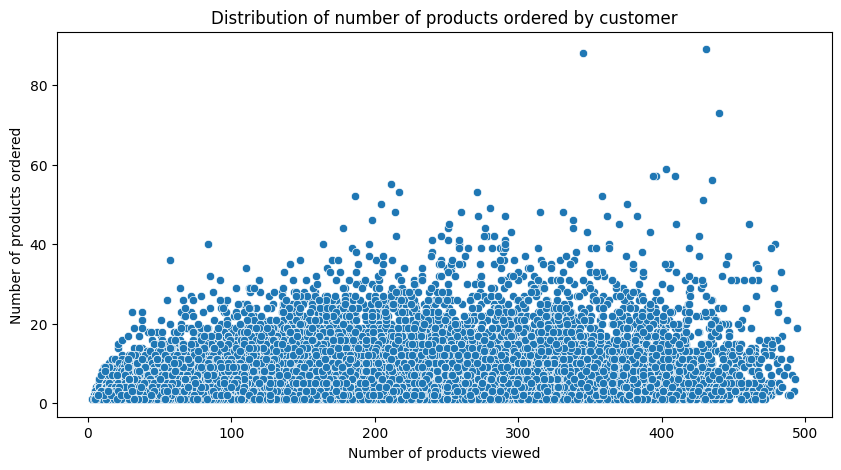

In [20]:
# plot trend between event count and event type orders
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_train_orders['event_count'], y=grouped_train_orders['aid_orders'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of products ordered')
plt.show()

### <a id='toc1_3_4_'></a>[Distribution of number of products ordered by customers](#toc0_)

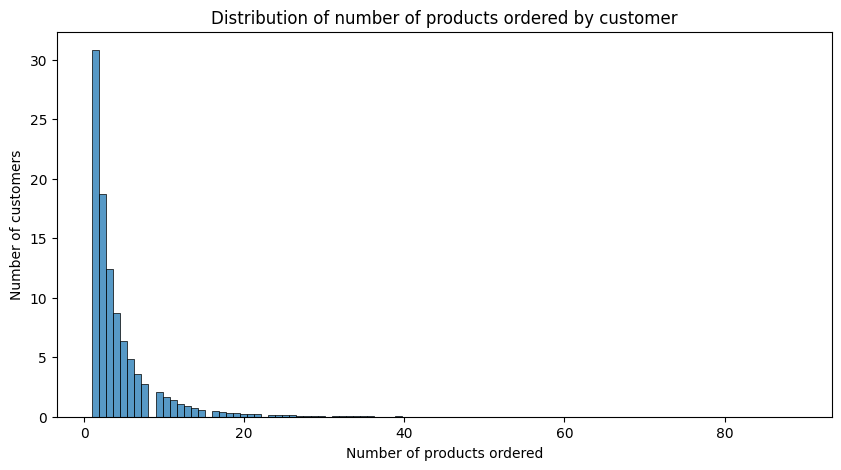

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_orders['aid_orders'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of customers')
plt.show()

### <a id='toc1_3_5_'></a>[Distribution of number of products clicked](#toc0_)

In [22]:
grouped_train_clicks = train[train['type'] == 'clicks'].groupby('session').count().join(grouped_train, lsuffix='_clicks', rsuffix='_views')   
grouped_train_clicks = grouped_train_clicks.drop(['aid_views', 'ts_views'], axis=1).rename(columns={'type_views': 'event_count'})
display(grouped_train_clicks)

,aid_clicks,ts_clicks,type_clicks,event_count
session,,,,
0,255,255,255,276
1,24,24,24,32
2,32,32,32,33
3,200,200,200,226
4,15,15,15,19
...,...,...,...,...
199995,17,17,17,17
199996,24,24,24,25
199997,119,119,119,154


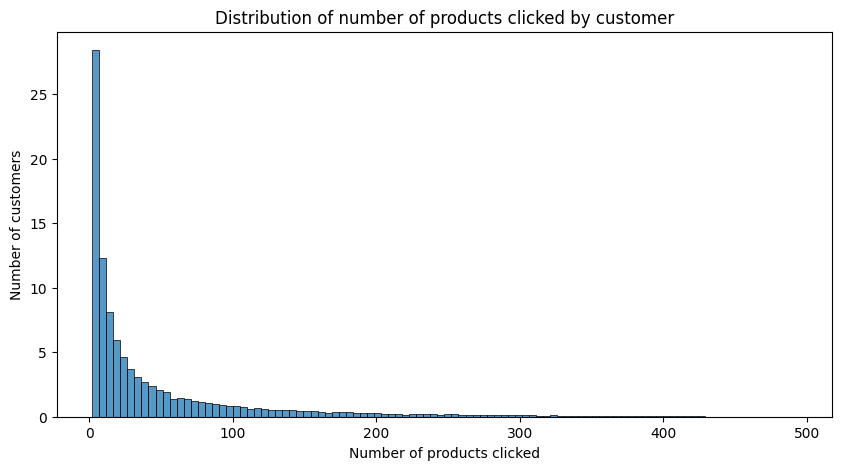

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_clicks['aid_clicks'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products clicked by customer')
plt.xlabel('Number of products clicked')
plt.ylabel('Number of customers')
plt.show()

### <a id='toc1_3_6_'></a>[Distribution of number of products added to cart](#toc0_)

In [24]:
grouped_train_carts = train[train['type'] == 'carts'].groupby('session').count().join(grouped_train, lsuffix='_carts', rsuffix='_views')
grouped_train_carts = grouped_train_carts.drop(['aid_views', 'ts_views'], axis=1).rename(columns={'type_views': 'event_count'})
display(grouped_train_carts)

,aid_carts,ts_carts,type_carts,event_count
session,,,,
0,17,17,17,276
1,8,8,8,32
2,1,1,1,33
3,21,21,21,226
4,3,3,3,19
...,...,...,...,...
199991,4,4,4,27
199992,14,14,14,153
199993,5,5,5,31


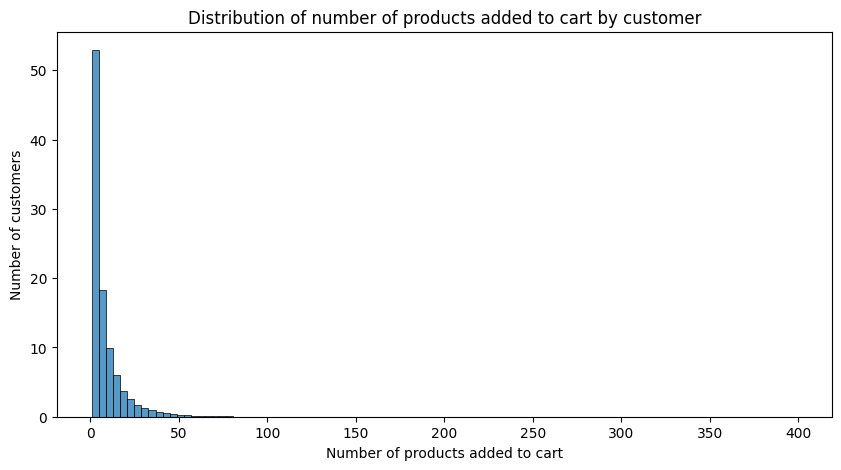

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(grouped_train_carts['aid_carts'], stat='percent', kde=False, bins=100)
plt.title('Distribution of number of products added to cart by customer')
plt.xlabel('Number of products added to cart')
plt.ylabel('Number of customers')
plt.show()

### <a id='toc1_3_7_'></a>[Number of products ordered vs. number of products clicked](#toc0_)

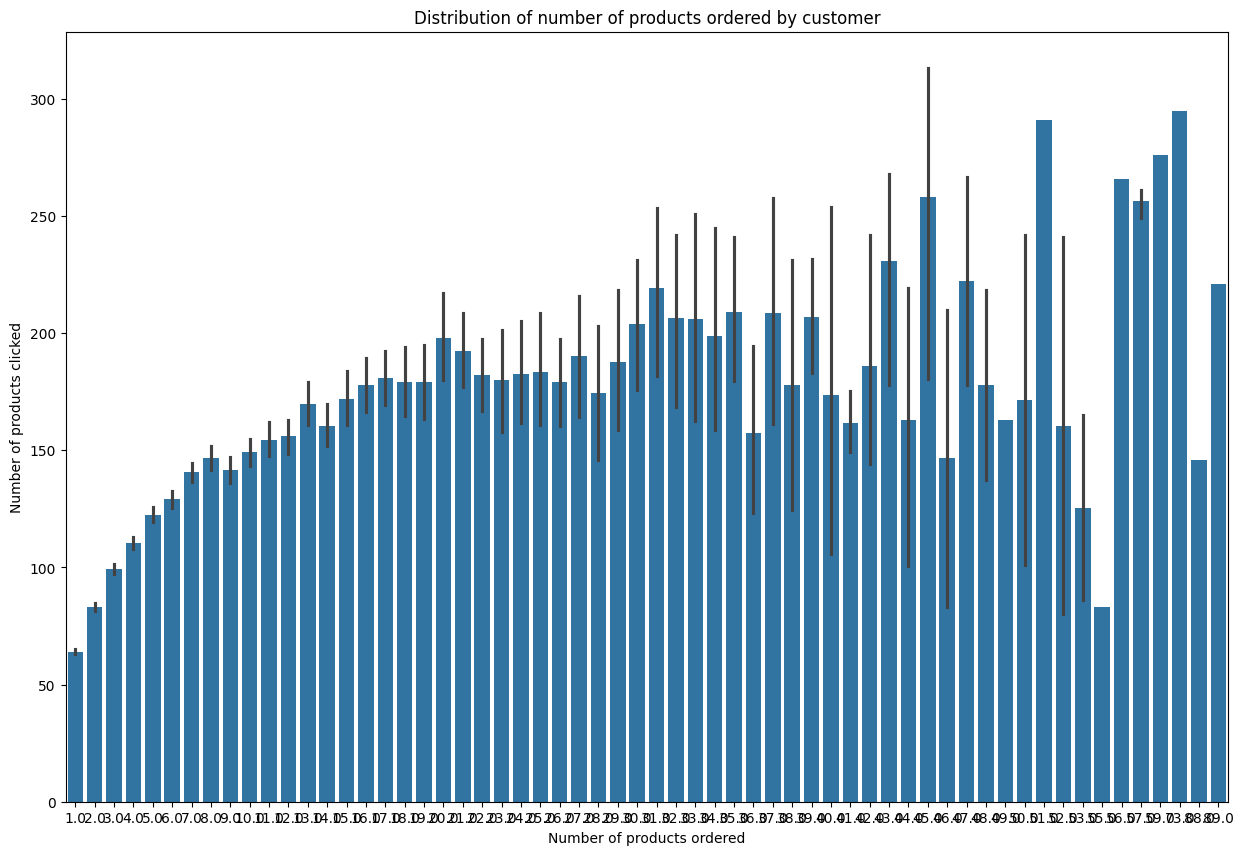

In [26]:
plt.figure(figsize=(15, 10))
sns.barplot(x=grouped_train_orders['aid_orders'], y=grouped_train_clicks['aid_clicks'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of products clicked')
plt.show()

### <a id='toc1_3_8_'></a>[Number of products ordered vs. number of products added to cart](#toc0_)

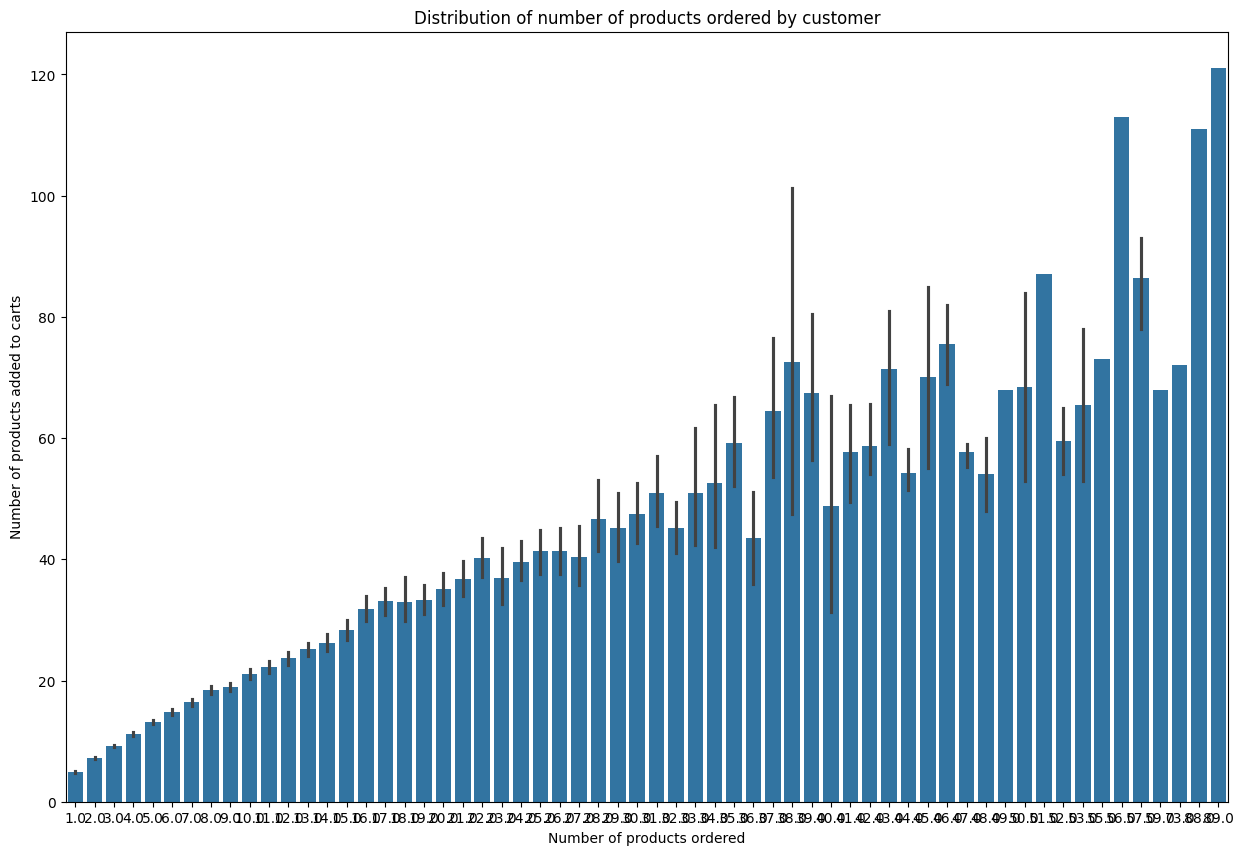

In [27]:
plt.figure(figsize=(15, 10))
sns.barplot(x=grouped_train_orders['aid_orders'], y=grouped_train_carts['aid_carts'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products ordered')
plt.ylabel('Number of products added to carts')
plt.show()

## Model Training



In [57]:
train = pl.read_parquet('../data/train.parquet')
valid = pl.read_parquet('../data/test.parquet')

In [58]:
# train_pairs = (train.groupby('session').agg([
#     pl.col('aid'),
#     pl.col('aid').shift(-1).alias('aid_next')
# ]).explode(['aid', 'aid_next']).drop_nulls())['aid', 'aid_next']

train_pairs = (train
    .groupby('session').agg([
        pl.col('aid'),
        pl.col('aid').shift(-1).alias('aid_next')
    ])
    .explode(['aid', 'aid_next'])
    .drop_nulls()
)[['aid', 'aid_next']]

In [59]:
valid_pairs = (valid
    .groupby('session').agg([
        pl.col('aid'),
        pl.col('aid').shift(-1).alias('aid_next')
    ])
    .explode(['aid', 'aid_next'])
    .drop_nulls()
)[['aid', 'aid_next']]

In [44]:
train_pairs.head()

aid,aid_next
i32,i32
100552,851187
945619,1675335
1675335,1671711
308495,323210
323210,308495


In [60]:
valid_pairs.head()

aid,aid_next
i32,i32
1603749,1582281
1582281,396620
813296,605373
1708890,722288
1723449,1627561


In [69]:
cardinality_aids = max(train_pairs['aid'].max(), train_pairs['aid_next'].max(), valid_pairs['aid'].max(), valid_pairs['aid_next'].max())
cardinality_aids

1855602

In [61]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class ClicksDataset(Dataset):
    def __init__(self, pairs):
        self.aid1 = pairs['aid'].to_numpy()
        self.aid2 = pairs['aid_next'].to_numpy()
    def __getitem__(self, idx):
        aid1 = self.aid1[idx]
        aid2 = self.aid2[idx]
        return [aid1, aid2]
    def __len__(self):
        return len(self.aid1)
    
train_ds = ClicksDataset(train_pairs)
valid_ds = ClicksDataset(valid_pairs)

In [65]:
train_pairs.to_pandas().to_parquet('train_pairs.parquet')
valid_pairs.to_pandas().to_parquet('valid_pairs.parquet')

In [66]:
from merlin.loader.torch import Loader 
from merlin.io import Dataset

train_ds = Dataset('train_pairs.parquet')
train_dl_merlin = Loader(train_ds, 65536, True)

In [67]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_aids, n_factors):
        super().__init__()
        self.aid_factors = nn.Embedding(n_aids, n_factors, sparse=True)
        
    def forward(self, aid1, aid2):
        aid1 = self.aid_factors(aid1)
        aid2 = self.aid_factors(aid2)
        
        return (aid1 * aid2).sum(dim=1)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

valid_ds = Dataset('valid_pairs.parquet')
valid_dl_merlin = Loader(valid_ds, 65536, True)

In [70]:
from torch.optim import SparseAdam

num_epochs=1
lr=0.1

model = MatrixFactorization(cardinality_aids+1, 32)
optimizer = SparseAdam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [71]:
%%time

for epoch in range(num_epochs):
    for batch, _ in train_dl_merlin:
        model.train()
        losses = AverageMeter('Loss', ':.4e')
            
        aid1, aid2 = batch['aid'], batch['aid_next']
        output_pos = model(aid1, aid2)
        output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
        
        output = torch.cat([output_pos, output_neg])
        targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_pos)])
        loss = criterion(output, targets)
        losses.update(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    
    with torch.no_grad():
        accuracy = AverageMeter('accuracy')
        for batch, _ in valid_dl_merlin:
            aid1, aid2 = batch['aid'], batch['aid_next']
            output_pos = model(aid1, aid2)
            output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
            accuracy_batch = torch.cat([output_pos.sigmoid() > 0.5, output_neg.sigmoid() < 0.5]).float().mean()
            accuracy.update(accuracy_batch, aid1.shape[0])
            
    print(f'{epoch+1:02d}: * TrainLoss {losses.avg:.3f}  * Accuracy {accuracy.avg:.3f}')

01: * TrainLoss 1.196  * Accuracy 0.700
CPU times: user 8min 40s, sys: 9min 51s, total: 18min 31s
Wall time: 4min 40s


In [72]:
embeddings = model.aid_factors.weight.detach().numpy()

In [73]:
%%time

from annoy import AnnoyIndex

index = AnnoyIndex(32, 'euclidean')
for i, v in enumerate(embeddings):
    index.add_item(i, v)
    
index.build(10)

CPU times: user 31.2 s, sys: 849 ms, total: 32.1 s
Wall time: 9.19 s


True

In [74]:
index.get_nns_by_item(123, 10)

[123,
 516574,
 473584,
 1659487,
 1256582,
 1264553,
 1217109,
 863940,
 1074573,
 598785]

In [77]:
test = pl.read_parquet('../archive/test.parquet')
test_labels = pl.read_parquet('../archive/test_labels.parquet')

In [78]:
import pandas as pd
import numpy as np

from collections import defaultdict

sample_sub = pd.read_csv('/Users/chronus/Data/code/Git-repo/machine learning/sample_submission.csv')

session_types = ['clicks', 'carts', 'orders']
test_session_AIDs = test.to_pandas().reset_index(drop=True).groupby('session')['aid'].apply(list)
test_session_types = test.to_pandas().reset_index(drop=True).groupby('session')['type'].apply(list)

labels = []

type_weight_multipliers = {0: 1, 1: 6, 2: 3}
for AIDs, types in zip(test_session_AIDs, test_session_types):
    if len(AIDs) >= 20:
        # if we have enough aids (over equals 20) we don't need to look for candidates! we just use the old logic
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
        aids_temp=defaultdict(lambda: 0)
        for aid,w,t in zip(AIDs,weights,types): 
            aids_temp[aid]+= w * type_weight_multipliers[t]
            
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
        labels.append(sorted_aids[:20])
    else:
        # here we don't have 20 aids to output -- we will use approximate nearest neighbor search and our embeddings
        # to generate candidates!
        AIDs = list(dict.fromkeys(AIDs[::-1]))
        
        # let's grab the most recent aid
        most_recent_aid = AIDs[0]
        
        # and look for some neighbors!
        nns = index.get_nns_by_item(most_recent_aid, 21)[1:]
                        
        labels.append((AIDs+nns)[:20])

In [79]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

In [80]:
display(submission)

,session_type,labels
0,11098528_clicks,11830 1689044 1502122 1758603 1695994 889686 1...
1,11098529_clicks,1105029 1468629 701788 1751978 1089689 536610 ...
2,11098530_clicks,409236 264500 1497089 258353 776749 460141 158...
3,11098531_clicks,1271998 1728212 396199 452188 1365569 624163 1...
4,11098532_clicks,876469 7651 1206327 659399 1159768 1841829 164...
...,...,...
5403748,12899774_orders,33035 1413049 208189 657625 1074901 990186 182...
5403749,12899775_orders,1743151 1760714 1236775 1733943 29735 1239687 ...
5403750,12899776_orders,548599 308581 250305 1723688 1577268 1572821 1...
5403751,12899777_orders,384045 1607328 881838 1789228 500570 379251 89...


In [81]:
display(test_labels)

session,type,ground_truth
i64,str,list[i64]
11098528,"""clicks""",[1679529]
11098528,"""carts""",[1199737]
11098528,"""orders""","[990658, 950341, … 1033148]"
11098529,"""clicks""",[1105029]
11098530,"""orders""",[409236]
…,…,…
12899774,"""clicks""",[1399483]
12899775,"""clicks""",[1760714]
12899776,"""clicks""",[1737908]
